In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import f_classif,SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib

import mlflow
import mlflow.sklearn

import warnings
warnings.simplefilter("always", category=UserWarning)

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# EDA

In [3]:
# shape of data
df.shape

(569, 32)

In [4]:
# information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
# checking null values
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [6]:
# drop column id
df = df.drop('id', axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Visualization

<Axes: xlabel='diagnosis', ylabel='count'>

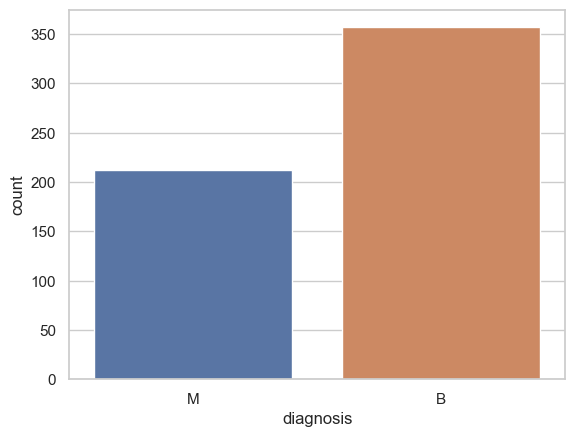

In [13]:
sns.countplot(data=df, x='diagnosis', hue='diagnosis')

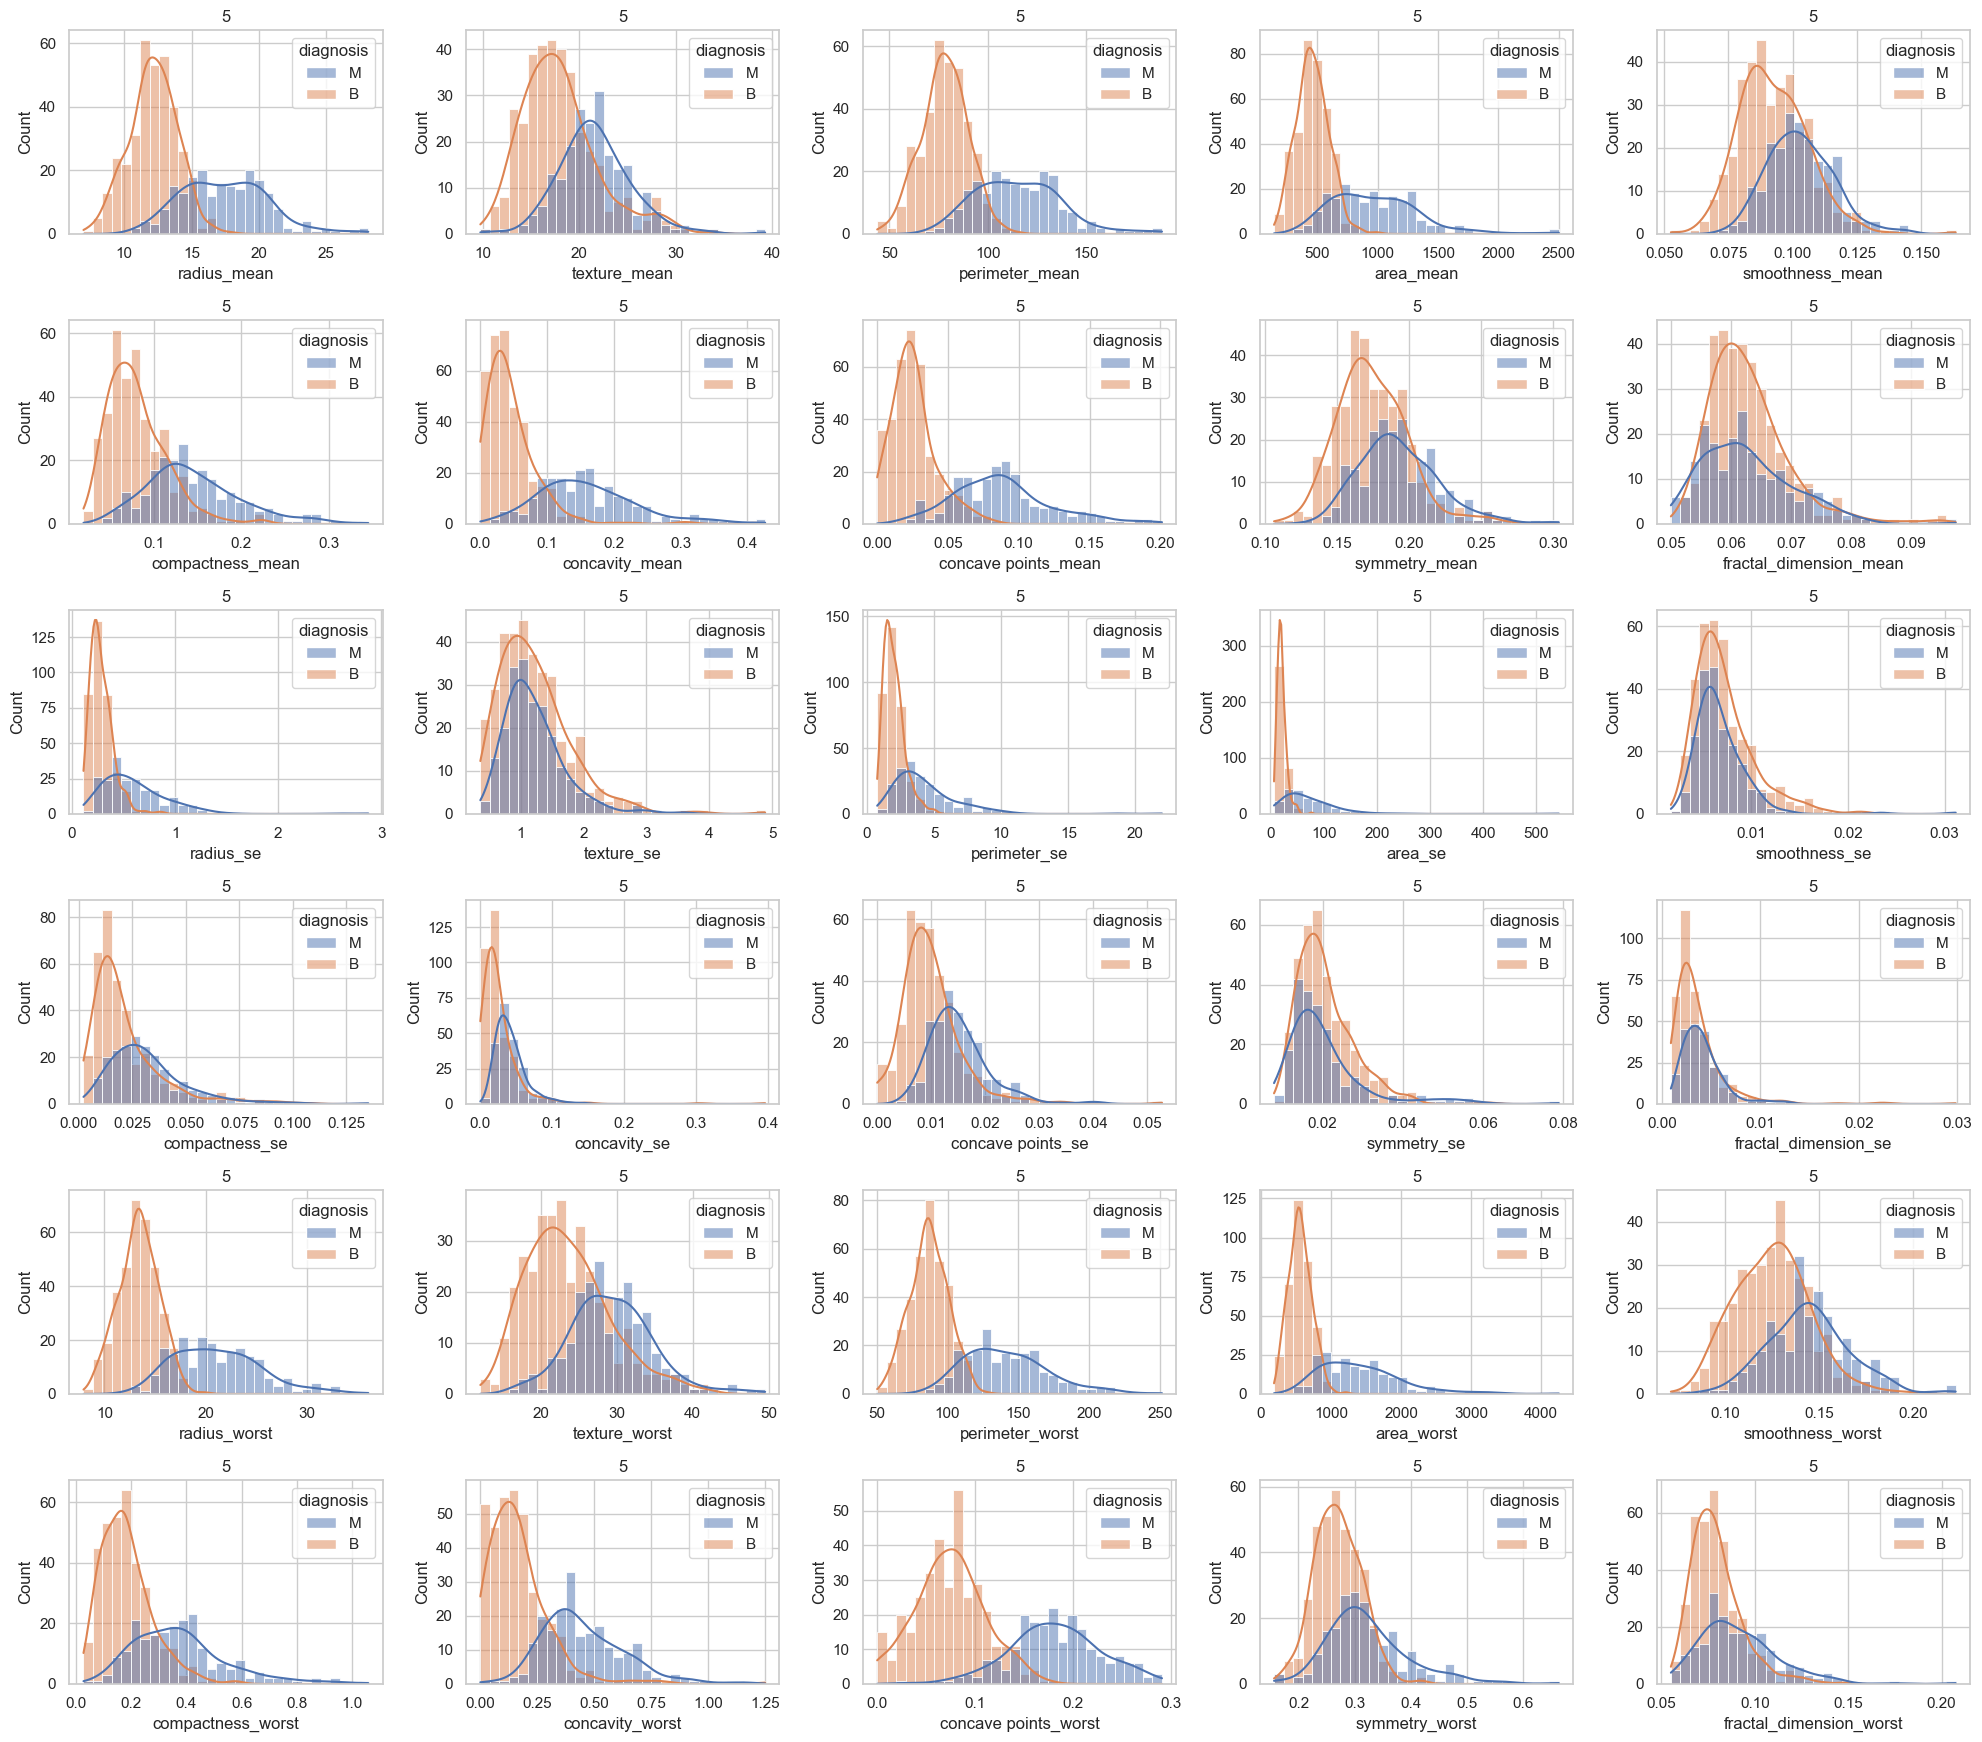

In [18]:
features = df.drop('diagnosis', axis=1)
plt.figure(figsize=(20,20))
col = 5
row = int(len(features.columns)/col) + 1

for id, features in enumerate(features.columns, 1):
    plt.subplot(row, col, id)
    sns.histplot(data=df, x=features, hue='diagnosis', bins=30, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

<Axes: >

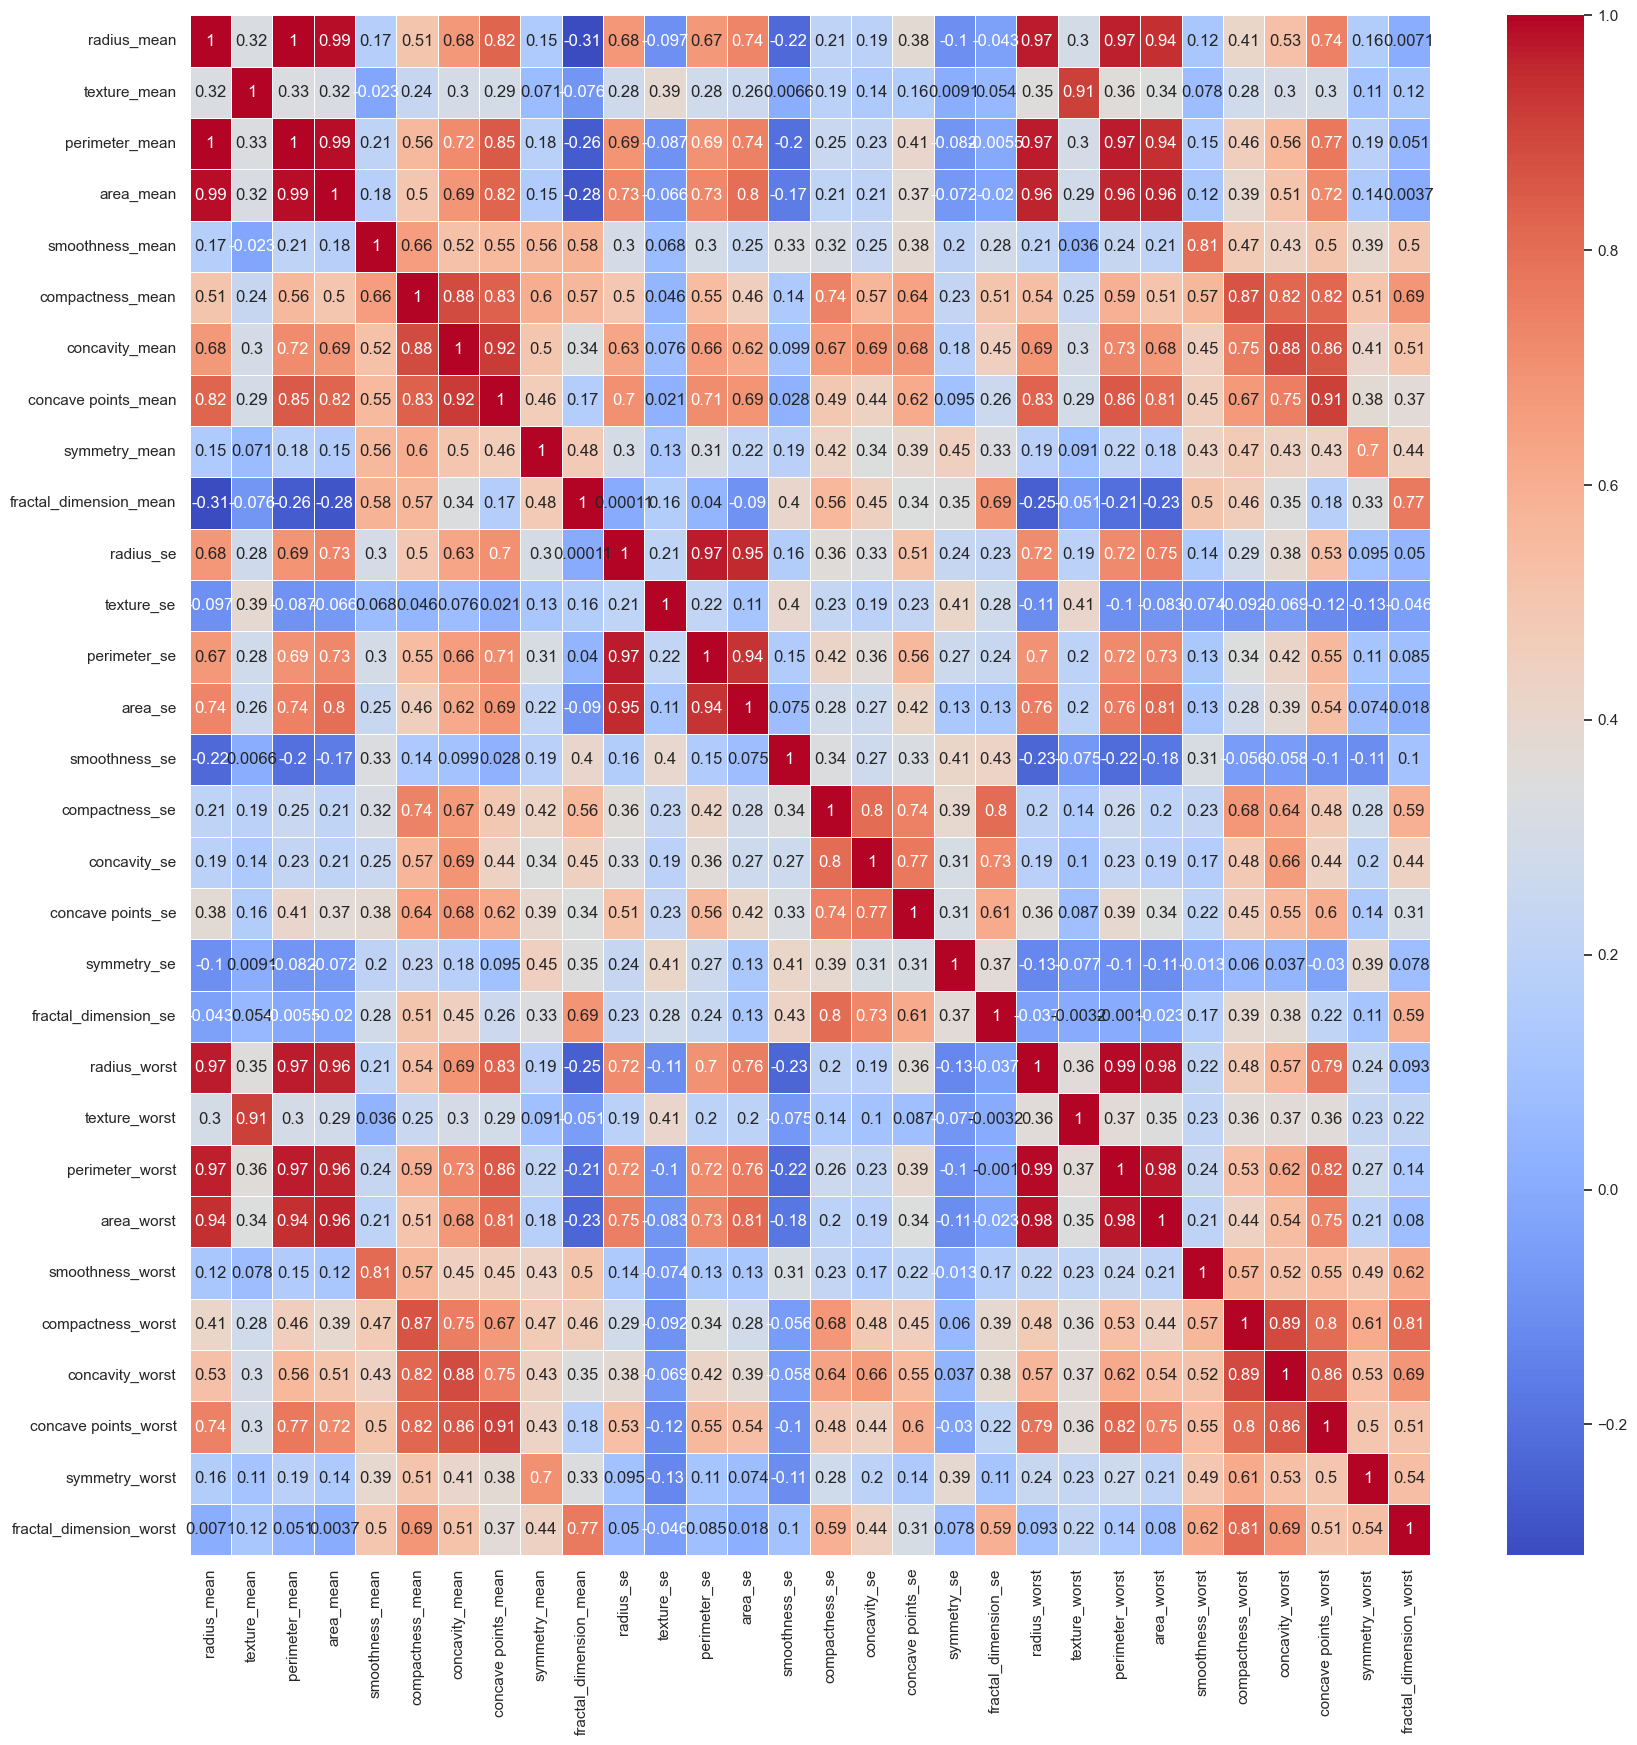

In [33]:
# heatmap shows the features tha have similarity var
features = df.drop('diagnosis', axis=1)
plt.figure(figsize=(20,20))
cor = features.corr()
sns.heatmap(data=cor, cmap='coolwarm', annot=True, linewidth = 0.7)


# Model Training

In [48]:
encoder = LabelEncoder()
df['diagnosis'] = encoder.fit_transform(df['diagnosis'])
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [49]:
df['diagnosis'].unique()

array([1, 0])

In [51]:
# features and Target Extraction

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']


In [54]:
#preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(),X.columns.tolist())
])


In [57]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [75]:
#models

models = {
    "LR" : {"model":LogisticRegression(), "params":{} },
    "DecisionTree" : {
                      "model":DecisionTreeClassifier(random_state=42,),
                      "params": {
                          "classifier__max_depth":[3,4,5], 
                                  }
                     },
    "XGBoost": {
                    "model": xgb.XGBClassifier(eval_metric="logloss"),
                    "params": {
                       "classifier__max_depth": [3, 4, 5],
                       "classifier__learning_rate": [0.05, 0.1]
                                }
                }
}


In [69]:
# ML FLow setup
mlflow.set_experiment("BreastCancerExp.")
mlflow.set_tracking_uri("http://localhost:5000")

2025/08/12 21:25:57 INFO mlflow.tracking.fluent: Experiment with name 'BreastCancerExp.' does not exist. Creating a new experiment.


In [93]:
# pipeline

best_overall_model = None
best_overall_acc = 0
best_overall_name = None

for name, model_df in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("anova", SelectKBest(score_func=f_classif, k=24)),
        ("classifier", model_df["model"])
    ])
    
    # grid
    grid = GridSearchCV(pipeline, model_df["params"], cv=5)
    grid.fit(X_train, y_train)
    
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    score = classification_report(y_test, y_pred)

    print("\n============== model ==================")
    print("\nModel: ", name)
    print("accuracy score: ", acc) 
    print("classification report: ",score)
    
    # MLflow logging
    with mlflow.start_run(run_name=name):
        # Log parameters
        mlflow.log_params(grid.best_params_)
        mlflow.log_param("anova_k", 20)
    
        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision_macro", report["macro avg"]["precision"])
        mlflow.log_metric("recall_macro", report["macro avg"]["recall"])
        mlflow.log_metric("f1_macro", report["macro avg"]["f1-score"])
    
        # Save model in MLflow
        mlflow.sklearn.log_model(best_model, name="model", input_example=X_train.iloc[:1])
     
    # Track best model overall
    if acc > best_overall_acc:
        best_overall_acc = acc
        best_overall_model = best_model
        best_overall_name = name
    
# Results
print(f"\nBest Model Accuracy: {acc:.4f}")
print(f"Best Model Name: {name}")
print("Best Parameters:", grid.best_params_)
        
    # Save best model locally

print("\n************* best model **************")
print("best model to be saved", best_overall_model)
joblib.dump(best_overall_model, "BestBreastCancerModel.pkl")
print("\nBest model saved as BestBreastCancerModel.pkl")



============== model ==================

Model:  LR
accuracy score:  0.965034965034965
classification report:                precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.98      0.92      0.95        53

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



C:\Users\ankit\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run LR at: http://localhost:5000/#/experiments/188433006347897724/runs/c8dd12ff2905415296138485094bfa38
🧪 View experiment at: http://localhost:5000/#/experiments/188433006347897724

============== model ==================

Model:  DecisionTree
accuracy score:  0.9020979020979021
classification report:                precision    recall  f1-score   support

           0       0.87      0.99      0.93        90
           1       0.98      0.75      0.85        53

    accuracy                           0.90       143
   macro avg       0.92      0.87      0.89       143
weighted avg       0.91      0.90      0.90       143



C:\Users\ankit\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run DecisionTree at: http://localhost:5000/#/experiments/188433006347897724/runs/8c5755e2695e497ba2051389405915a5
🧪 View experiment at: http://localhost:5000/#/experiments/188433006347897724

============== model ==================

Model:  XGBoost
accuracy score:  0.958041958041958
classification report:                precision    recall  f1-score   support

           0       0.94      1.00      0.97        90
           1       1.00      0.89      0.94        53

    accuracy                           0.96       143
   macro avg       0.97      0.94      0.95       143
weighted avg       0.96      0.96      0.96       143



C:\Users\ankit\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run XGBoost at: http://localhost:5000/#/experiments/188433006347897724/runs/0a13c919b7214b95882ea700c42ab490
🧪 View experiment at: http://localhost:5000/#/experiments/188433006347897724

Best Model Accuracy: 0.9580
Best Model Name: XGBoost
Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 4}

************* best model **************
best model to be saved Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                     